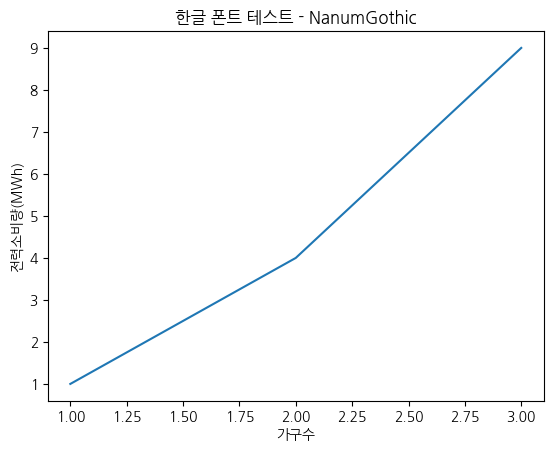

In [ ]:
# 1) 나눔고딕 설치
!apt-get -qq install -y fonts-nanum > /dev/null

# 2) Matplotlib에 '파일 경로로' 폰트를 직접 등록 (재시작 불필요)
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import os

# 나눔고딕 파일 경로 (콜랩 기본 경로)
candidates = [
    "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
    "/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf",
    "/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf",
]
font_path = next((p for p in candidates if os.path.exists(p)), None)

if font_path is None:
    # 대체로 Noto CJK도 시도
    !apt-get -qq install -y fonts-noto-cjk > /dev/null
    candidates_noto = [
        "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",
        "/usr/share/fonts/opentype/noto/NotoSansCJKkr-Regular.otf",
        "/usr/share/fonts/opentype/noto/NotoSansCJK-Medium.ttc",
    ]
    font_path = next((p for p in candidates_noto if os.path.exists(p)), None)

if font_path is None:
    raise FileNotFoundError("한글 폰트 파일을 찾지 못했습니다. fonts-nanum 또는 fonts-noto-cjk 설치를 확인해주세요.")

# 인라인 등록 → 즉시 사용 가능
fm.fontManager.addfont(font_path)

# 폰트 패밀리 이름은 보통 파일 내 이름과 동일 (NanumGothic 또는 Noto Sans CJK KR)
# 안전하게 이름 후보를 몇 개 돌려서 먼저 적용되는 걸로 사용
possible_families = ["NanumGothic", "Nanum Gothic", "Noto Sans CJK KR", "Noto Sans CJK"]
for fam in possible_families:
    try:
        rcParams["font.family"] = fam
        rcParams["axes.unicode_minus"] = False
        # 테스트 플롯
        plt.figure()
        plt.title(f"한글 폰트 테스트 - {fam}")
        plt.plot([1,2,3], [1,4,9])
        plt.xlabel("가구수")
        plt.ylabel("전력소비량(MWh)")
        plt.show()
        break
    except Exception as e:
        continue


In [ ]:
import pandas as pd

# 1) 인구 데이터
df_people = pd.read_csv("시도별_인구수_변환완료.csv", encoding="cp949")

# 2) 전력 데이터 (2018~2023)
df_power = pd.read_csv("주거용_판매전력량_2018_2023.csv", encoding="utf-8-sig")

# 3) 세대수 데이터
df_home = pd.read_csv("시군별_세대수_1823.csv", encoding="cp949")


In [ ]:
import re, unicodedata
import pandas as pd
import numpy as np

# ========== 공통 ==========
years = [2018, 2019, 2020, 2021, 2022, 2023]
region_map = {
    "전국":"전국","서울특별시":"서울","부산광역시":"부산","대구광역시":"대구","인천광역시":"인천",
    "광주광역시":"광주","대전광역시":"대전","울산광역시":"울산","세종특별자치시":"세종",
    "경기도":"경기","강원특별자치도":"강원","충청북도":"충북","충청남도":"충남",
    "전라북도":"전북","전라남도":"전남","경상북도":"경북","경상남도":"경남","제주특별자치도":"제주"
}

def norm_header(s):  # 헤더 공백/유니코드 정규화
    s = unicodedata.normalize("NFKC", str(s)).replace("\u00a0", " ")
    return s.strip()

def to_sido_label(sr):  # 시군구 → 시도 라벨링
    s = sr.astype(str).str.strip()
    out = s.map(region_map)
    need = out.isna()
    if need.any():
        sido = s[need].str.extract(r"^([^ ]+특별[자치]?시|[^ ]+광역시|[^ ]+특별자치도|..도)")[0]
        out.loc[need] = sido.map(region_map)
    return out.fillna(s)

def to_numeric_strip(df, cols):  # 숫자형 치환
    for c in cols:
        if c in df.columns:
            df[c] = (df[c].astype(str).str.replace(",", "", regex=False)
                               .replace({"-": np.nan}).astype(float))
    return df

# ========== 1) 인구: df_people ==========
if "지역" not in df_people.columns:
    df_people = df_people.rename(columns={df_people.columns[0]: "지역"})
df_people["지역"] = to_sido_label(df_people["지역"])

# 연도 시작 컬럼만 2018_인구 형식으로
people_rename = {c: f"{m.group(1)}_인구"
                 for c in df_people.columns
                 if (m:=re.match(r"(\d{4})", str(c))) and int(m.group(1)) in years}
df_people = df_people.rename(columns=people_rename).groupby("지역", as_index=False).sum(numeric_only=True)
df_people = to_numeric_strip(df_people, [f"{y}_인구" for y in years if f"{y}_인구" in df_people.columns])

# ========== 2) 전력: df_power ==========
if "지역" not in df_power.columns:
    df_power = df_power.rename(columns={df_power.columns[0]: "지역"})
df_power["지역"] = to_sido_label(df_power["지역"])

power_rename = {c: f"{c}_가정용전기사용량" for c in df_power.columns if str(c).isdigit() and int(c) in years}
df_power = df_power.rename(columns=power_rename).groupby("지역", as_index=False).sum(numeric_only=True)
df_power = to_numeric_strip(df_power, [f"{y}_가정용전기사용량" for y in years if f"{y}_가정용전기사용량" in df_power.columns])

# ========== 3) 세대수: df_home → 2018년전체세대 … ==========
if "지역" not in df_home.columns:
    df_home = df_home.rename(columns={df_home.columns[0]: "지역"})
df_home.columns = [norm_header(c) for c in df_home.columns]
df_home["지역"] = to_sido_label(df_home["지역"])

def is_total_household(col):  # '전체/총' + '세대/가구' & 1~9인 세대 제외
    c = norm_header(col)
    if re.search(r"[1-9]인\s*세대", c): return False
    return (("전체" in c) or ("총" in re.sub(r"\s+","",c))) and (("세대" in c) or ("가구" in c))

cands = [c for c in df_home.columns if c != "지역" and is_total_household(c)]

# 연/월 파싱해서 같은 연도는 가장 늦은 월(없으면 0) 선택
best = {}  # year -> (month, col)
for c in cands:
    cc = norm_header(c)
    y = re.search(r"(\d{4})\s*년?", cc)
    if not y: continue
    y = int(y.group(1))
    if y not in years: continue
    m = re.search(r"(1[0-2]|[1-9])\s*월", cc)
    m = int(m.group(1)) if m else 0
    if (y not in best) or (m > best[y][0]): best[y] = (m, c)

sel_pairs = [(y, best[y][1]) for y in sorted(best)]          # [(연도, 컬럼명), ...]
sel_cols  = [c for (_, c) in sel_pairs]                      # 선택 컬럼 목록
rename_map_home = {c: f"{y}년전체세대" for (y, c) in sel_pairs}

df_home = df_home[["지역"] + sel_cols].rename(columns=rename_map_home)
num_cols = [c for c in df_home.columns if c.endswith("년전체세대")]
df_home = to_numeric_strip(df_home, num_cols).groupby("지역", as_index=False).sum(numeric_only=True)

# 전력 + 세대수 + 인구 병합
df_all = (
    df_power.merge(df_home, on="지역", how="inner")
            .merge(df_people, on="지역", how="inner")
            .sort_values("지역")
            .reset_index(drop=True)
)

print("통합 데이터 미리보기:")
print(df_all.head())
print("통합 데이터 shape:", df_all.shape)

# # ========== 4) 결과 확인(필요 시) ==========
# print("인구:", [c for c in df_people.columns if c != "지역"][:6], "...")
# print("전력:", [c for c in df_power.columns if c != "지역"][:6], "...")
# print("세대:", [c for c in df_home.columns if c != "지역"][:6], "...")


통합 데이터 미리보기:
   지역  2018_가정용전기사용량  2019_가정용전기사용량  2020_가정용전기사용량  2021_가정용전기사용량  \
0  강원      2060563.0   2.081091e+06      2197106.0      2289719.0   
1  경기     18016468.0   1.822849e+07     19387551.0     20775255.0   
2  광주      2056435.0   2.038974e+06      2154034.0      2215918.0   
3  대구      3314918.0   3.252483e+06      3411777.0      3461331.0   
4  대전      1970225.0   1.938646e+06      2019639.0      2102655.0   

   2022_가정용전기사용량  2023_가정용전기사용량  2018년전체세대  2019년전체세대  2020년전체세대  2021년전체세대  \
0      2332245.0      2347691.0   707245.0   719524.0   736301.0   746220.0   
1     21128150.0     21681941.0  5306214.0  5468920.0  5676401.0  5841995.0   
2      2249750.0      2261231.0   603107.0   616485.0   633582.0   645712.0   
3      3580477.0      3643338.0  1021266.0  1031251.0  1056627.0  1063893.0   
4      2142124.0      2171029.0   624965.0   635343.0   652783.0   664417.0   

   2022년전체세대  2023년전체세대     2018_인구     2019_인구     2020_인구     2021_인구  \
0   755481.0   760635.

In [ ]:
# 1) 파생지표: 세대당/1인당 전력

for y in years:
    p  = f"{y}_가정용전기사용량"
    hh = f"{y}년전체세대"
    pe = f"{y}_인구"
    df_all[f"{y}_세대당전력"] = df_all[p] / df_all[hh].replace({0: np.nan})
    df_all[f"{y}_1인당전력"]  = df_all[p] / df_all[pe].replace({0: np.nan})


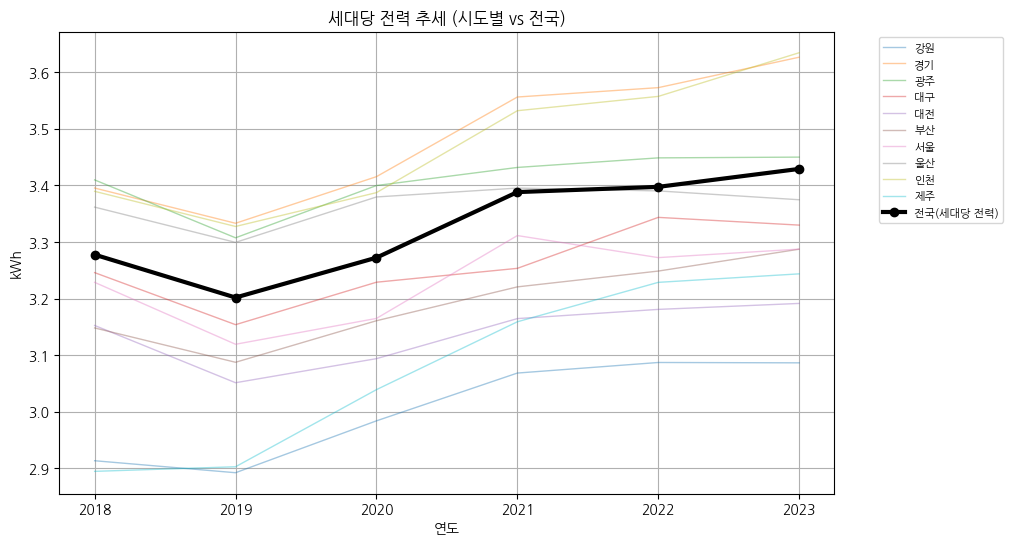

In [ ]:
# 세대당 전력 추세 구하기
import matplotlib.pyplot as plt
import numpy as np

Y = years

plt.figure(figsize=(10,6))

# --- 1) 시도별 라인 ---
for _, row in df_all.iterrows():
    region = row["지역"]
    vals = [row[f"{y}_세대당전력"] for y in Y]
    plt.plot(Y, vals, alpha=0.4, linewidth=1, label=region)

# --- 2) 전국 합계 라인 ---
natl_se = []
for y in Y:
    P  = df_all[f"{y}_가정용전기사용량"].sum()
    HH = df_all[f"{y}년전체세대"].sum()
    natl_se.append(P / HH if HH else np.nan)

plt.plot(Y, natl_se, marker="o", linewidth=3, color="black", label="전국(세대당 전력)")

plt.title("세대당 전력 추세 (시도별 vs 전국)")
plt.xlabel("연도"); plt.ylabel("kWh")
plt.grid(True); plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=8)
plt.show()


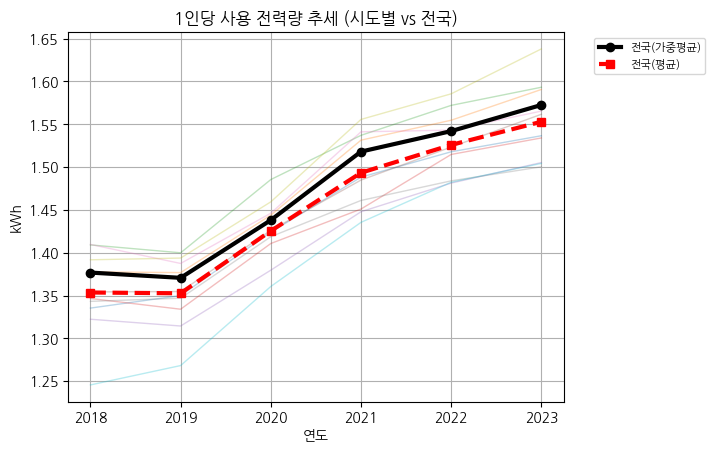

In [ ]:
# 1인당 사용 전력량 추세 그리기
# --- 시도별 라인 ---
for _, row in df_all.iterrows():
    region = row["지역"]
    vals = [row[f"{y}_1인당전력"] for y in Y]
    plt.plot(Y, vals, alpha=0.3, linewidth=1)

# --- 전국 전체 (가중평균) ---
natl_pe = [df_all[f"{y}_가정용전기사용량"].sum() / df_all[f"{y}_인구"].sum() for y in Y]
plt.plot(Y, natl_pe, marker="o", linewidth=3, color="black", label="전국(가중평균)")

# --- 전국 평균 (단순평균) ---
natl_pe_avg = [df_all[f"{y}_1인당전력"].mean() for y in Y]
plt.plot(Y, natl_pe_avg, marker="s", linewidth=3, color="red", linestyle="--", label="전국(평균)")

plt.title("1인당 사용 전력량 추세 (시도별 vs 전국)")
plt.xlabel("연도"); plt.ylabel("kWh")
plt.grid(True); plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=8)
plt.show()


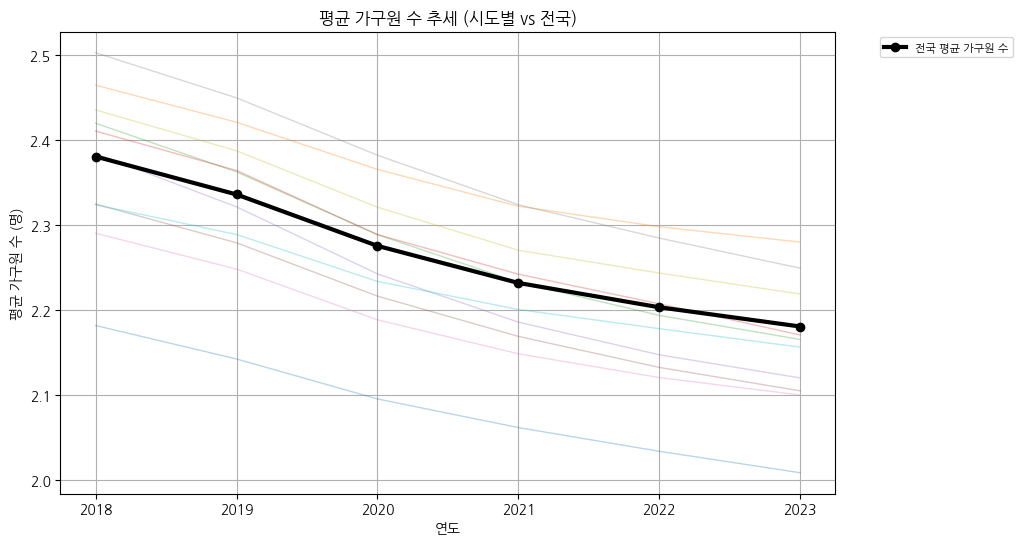

In [ ]:
# 평균 가구원 수 추세
import matplotlib.pyplot as plt

Y = years

plt.figure(figsize=(10,6))

# --- 시도별 라인 ---
for _, row in df_all.iterrows():
    region = row["지역"]
    vals = [row[f"{y}_인구"] / row[f"{y}년전체세대"] for y in Y]
    plt.plot(Y, vals, alpha=0.3, linewidth=1)

# --- 전국 전체 평균 가구원 수 ---
natl_avg = []
for y in Y:
    total_people = df_all[f"{y}_인구"].sum()
    total_home   = df_all[f"{y}년전체세대"].sum()
    natl_avg.append(total_people / total_home)

plt.plot(Y, natl_avg, marker="o", linewidth=3, color="black", label="전국 평균 가구원 수")

plt.title("평균 가구원 수 추세 (시도별 vs 전국)")
plt.xlabel("연도"); plt.ylabel("평균 가구원 수 (명)")
plt.grid(True); plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=8)
plt.show()


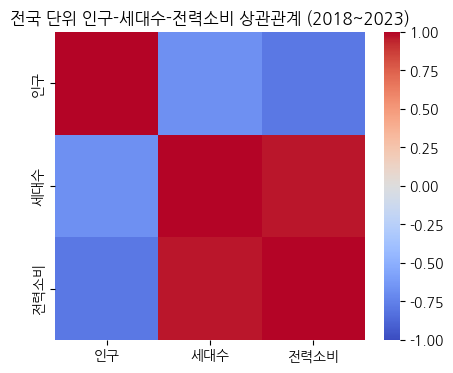

In [ ]:
# 인구/세대수/가정용전력소비량 상관관계 히트맵 그리기
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- 1) 전국 합계 시계열 만들기 ---
natl = pd.DataFrame({
    "연도": years,
    "인구": [df_all[f"{y}_인구"].sum() for y in years],
    "세대수": [df_all[f"{y}년전체세대"].sum() for y in years],
    "전력소비": [df_all[f"{y}_가정용전기사용량"].sum() for y in years],
})

# --- 2) 상관행렬 ---
corr = natl[["인구","세대수","전력소비"]].corr(method="pearson")

# --- 3) 히트맵 ---
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=False, fmt=".2f",
            cmap="coolwarm", vmin=-1, vmax=1,
            xticklabels=["인구","세대수","전력소비"],
            yticklabels=["인구","세대수","전력소비"])
plt.title("전국 단위 인구-세대수-전력소비 상관관계 (2018~2023)")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# ------------------------
# 1) 전국 세대당 전력 (연간)
# ------------------------
years = [2018,2019,2020,2021,2022,2023]
Y = pd.PeriodIndex(years, freq="Y")

vals = []
for y in years:
    P = df_all[f"{y}_가정용전기사용량"].sum()    # 전국 전력소비 합계
    H = df_all[f"{y}년전체세대"].sum()          # 전국 세대수 합계
    vals.append(P/H if H else np.nan)

ts_y = pd.Series(vals, index=Y, name="세대당 전력사용량(연간)")
print("연간 시계열:\n", ts_y)

# ------------------------
# 2) 월별 보간 (2018.01 ~ 2023.12)
# ------------------------
ts_m = ts_y.to_timestamp('Y').resample('M').interpolate('linear')
ts_m.name = "세대당 전력사용량(월별보간)"

plt.figure(figsize=(9,4))
plt.plot(ts_m, marker="o", linewidth=1)
plt.title(ts_m.name)
plt.grid(True); plt.show()


연간 시계열:
 2018    3.277664
2019    3.201858
2020    3.272337
2021    3.388192
2022    3.397443
2023    3.429144
Freq: Y-DEC, Name: 세대당 전력사용량(연간), dtype: float64


/tmp/ipython-input-4129825446.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_m = ts_y.to_timestamp('Y').resample('M').interpolate('linear')


ADF(원시계열): stat=-1.386, p=0.589
ADF(1차 차분): stat=-1.947, p=0.310


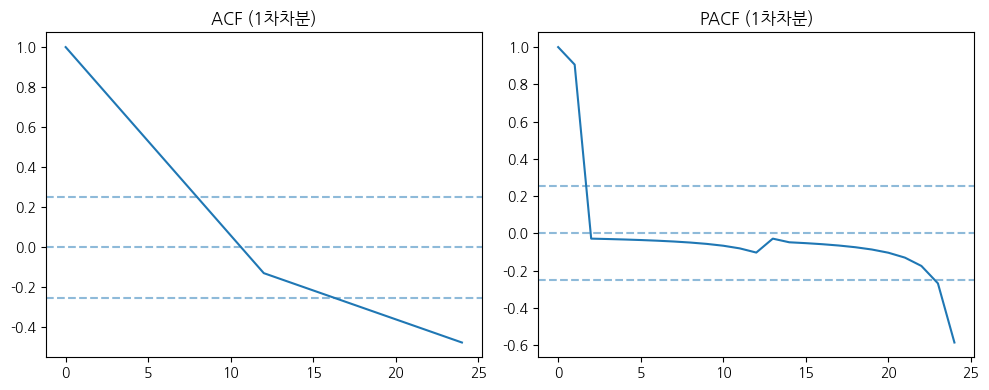

In [ ]:
# 정상성 체크 & 차분 (ACF/PACF 확인)
# ADF (정상성 검정)
adf_stat, adf_p = adfuller(ts_m.values, autolag='AIC')[:2]
print(f"ADF(원시계열): stat={adf_stat:.3f}, p={adf_p:.3f}")

tsd = ts_m.diff().dropna()
adf_stat_d, adf_p_d = adfuller(tsd.values, autolag='AIC')[:2]
print(f"ADF(1차 차분): stat={adf_stat_d:.3f}, p={adf_p_d:.3f}")

# ACF / PACF
nlags = 24
conf = 1.96/np.sqrt(len(tsd))
acf_vals  = acf(tsd, nlags=nlags)
pacf_vals = pacf(tsd, nlags=nlags, method='ols')

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(acf_vals);  plt.axhline(0, ls='--', alpha=.5)
plt.axhline(conf, ls='--', alpha=.5); plt.axhline(-conf, ls='--', alpha=.5)
plt.title("ACF (1차차분)")
plt.subplot(1,2,2); plt.plot(pacf_vals); plt.axhline(0, ls='--', alpha=.5)
plt.axhline(conf, ls='--', alpha=.5); plt.axhline(-conf, ls='--', alpha=.5)
plt.title("PACF (1차차분)")
plt.tight_layout(); plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

train = ts_m[:-12]   # 2018-01 ~ 2022-12
test  = ts_m[-12:]   # 2023-01 ~ 2023-12

print("Train:", train.index[0].strftime("%Y-%m"), "~", train.index[-1].strftime("%Y-%m"))
print("Test :", test.index[0].strftime("%Y-%m"),  "~", test.index[-1].strftime("%Y-%m"))

def arima_grid_with_trend(y, p_max=5, q_max=5, d=1, trends=('c','t','ct')):
    best = {"aic": np.inf, "order": None, "trend": None, "res": None}
    for p in range(p_max+1):
        for q in range(q_max+1):
            for tr in trends:
                try:
                    m = ARIMA(y, order=(p,d,q), trend=tr,
                              enforce_stationarity=False, enforce_invertibility=False)
                    r = m.fit(method_kwargs={"maxiter":500})
                    if r.aic < best["aic"]:
                        best = {"aic": r.aic, "order": (p,d,q), "trend": tr, "res": r}
                except Exception:
                    pass
    return best

best = arima_grid_with_trend(train, p_max=5, q_max=5, d=1, trends=('c','t','ct'))
order, trend = best["order"], best["trend"]
res = best["res"]
print(f"Best ARIMA order on Train: {order}, trend='{trend}', AIC={best['aic']:.2f}")
print(res.summary())

Train: 2018-12 ~ 2022-12
Test : 2023-01 ~ 2023-12


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best ARIMA order on Train: (1, 1, 0), trend='t', AIC=-436.12
                               SARIMAX Results                                
Dep. Variable:        세대당 전력사용량(월별보간)   No. Observations:                   49
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 221.058
Date:                Wed, 03 Sep 2025   AIC                           -436.115
Time:                        07:33:50   BIC                           -430.565
Sample:                    12-31-2018   HQIC                          -434.027
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0042      0.004      0.983      0.326      -0.004       0.012
ar.L1          0.9078      0.148      6.123      0.000       0.617    

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:

# 24개월 예측 (2023~2024)
fc  = res.get_forecast(steps=24)
pred = fc.predicted_mean
ci   = fc.conf_int()

# 백테스트 성능(2023) & 기울기 비교
pred_2023 = pred.iloc[:12]
mape = mean_absolute_percentage_error(test, pred_2023)
rmse = np.sqrt(mean_squared_error(test, pred_2023))
print(f"Backtest 2023 — MAPE: {mape:.3f}, RMSE: {rmse:.6f}")

# 실제(2023) vs 예측(2023) 기울기(연율 환산, 단순: 첫-끝 차이)
slope_actual = (test.iloc[-1] - test.iloc[0]) / 12.0
slope_pred   = (pred_2023.iloc[-1] - pred_2023.iloc[0]) / 12.0
print(f"2023 기울기(월평균 증가): 실제={slope_actual:.6f}, 예측={slope_pred:.6f}")

# 시각화 (2018~2024 전체 표시)
plt.figure(figsize=(11,5))

# (A) Train 2018~2022
plt.plot(train.index, train, label="Train (2018-2022)", color="blue")

# (B) Actual 2023
plt.plot(test.index,  test,  label="Actual 2023", color="black", linestyle="--")

# (C) Forecast 2023~2024 (trend 포함 ARIMA)
label_fc = f"Forecast 2023-2024  ARIMA{order}, trend='{trend}'"
plt.plot(pred.index, pred, label=label_fc, color="red")

# (D) 95% 신뢰구간
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color="pink", alpha=0.3, label="95% CI")

# (E) 경계선
plt.axvline(test.index[0],  color="gray", linestyle=":", linewidth=1)   # 2023 시작
plt.axvline(pred.index[12], color="gray", linestyle=":", linewidth=1)   # 2024 시작

plt.title(f"기울기 반영 ARIMA 백테스트+예측 — {ts_m.name}")
plt.xlabel("연도"); plt.ylabel("세대당 전력사용량 (kWh/세대)")
plt.grid(True); plt.legend()
plt.show()


Backtest 2023 — MAPE: 0.001, RMSE: 0.004860
2023 기울기(월평균 증가): 실제=0.002422, 예측=0.002161
